# Spotify Popularity Predictor

## Project Goals
Discover drivers of popularity.
Predict the popularity of songs based on user's top artists.

## Project Description
This project utilizes a user's Spotify data to retrieve the discography of each artist in the user's top artists, analyzes audio features, creates clusters based on similar features, and then uses machine learning to create a regression model that predicts the popularity of each song.

## Initial Questions
1. Can meaningful clusters be created from Spotify's audio features?
2. Does a song's dancability correlate with popularity?
3. Does a song's tempo correlate with popularity?
4. Does a song's key and mode correlate with popularity?

## Data Dictionary
| variable      | meaning       |
| ------------- |:-------------:|
|popularity|target value: Popularity of the artist, calculated by popularity of all artist's tracks|
|lm|Ordinary Least Squares Linear Regression modeling algorithm|
|lm2|Polynomial Regression modeling algorithm |
|glm|TweedieRegressor modeling algorithm|
|Audio Features|
|acousticness|confidence measure of whether the track is acoustic|
|danceability|how suitable a track is for dancing|
|duration_minutes|duration of track in minutes, rounded to the nearest whole minute|
|energy|perceptual measure of intensity and activity|
|instrumentalness|predicts whether a track contains no vocals|
|key|the key the track is in|
|liveness|presence of an audience in the recording|
|loudness|overall loudness of a track in decibels|
|mode|indicates modality, with 1 being major and 0 being minor|
|speechiness|presence of spoken words in a track, with 1 being a talk show or podcast|
|tempo|overall estimated pace of a track in beats per minute|
|time_signature|estimated meter of beats in a bar, ranging from 3/4 to 7/4|
|valence|measure of how positive a song sounds|

## Wrangling Spotify Data
Utilizing Spotify's Web API and the spotipy library, a dataframe is made using the user's top artists' discographies. The song URI is used to pull their audio features and are then merged onto the dataframe.

In [1]:
# import modules
import pandas as pd

#import visualizations
import viz

# ignore warnings to reduce clutter
import warnings
warnings.filterwarnings("ignore")

# Import wrangle module with functions to acquire, prepare, scale, and split data from Spotify's API
import wrangle

# execute functions to acquire and split a df and store in train, validate, and test dataframes
df = wrangle.get_spotify_top_artists_discography_data()
train, validate, test = wrangle.split_data(df)
scaler, train_scaled, validate_scaled, test_scaled = wrangle.standard_scaler(train, validate, test)

Data preparation is executed by:
- Converting duration_ms to duration_minutes
- Ensuring no nulls are in the data
- Dropping duplicate values

## Data Landscape
- Discographies from 860 artists
- 15K songs
- 13 audio features

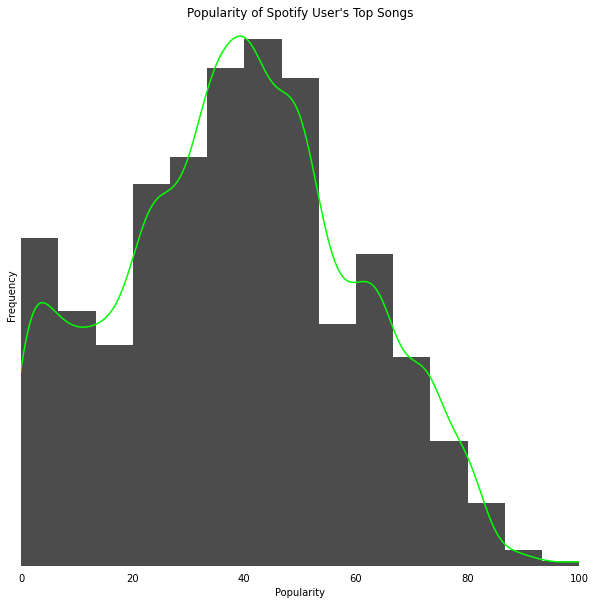

In [2]:
viz.data_landscape(df)

## Clustering
Clusters are created with KMeans using scaled data.

### What clusters make sense?
Clusters are created based on features that relate to eachother musically.

- beat_cluster: tempo, energy, danceability

- mood_cluster: mode, key, and valence

- ambience_cluster: acousticness, intrumentalness, loudness

The number of clusters (k) was found using the elbow method.

### Beat Cluster
tempo, energy, and danceability

In [3]:
# import clustering module
from sklearn.cluster import KMeans

# define features for clustering
X_train_beat_cluster = train_scaled[['tempo','energy','danceability']]
X_validate_beat_cluster = validate_scaled[['tempo','energy','danceability']]
X_test_beat_cluster = test_scaled[['tempo','energy','danceability']]

# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 222)
# fit cluster object to features
kmeans.fit(X_train_beat_cluster)
# use the object
train_scaled['beat_cluster'] = kmeans.predict(X_train_beat_cluster)
validate_scaled['beat_cluster'] = kmeans.predict(X_validate_beat_cluster)
test_scaled['beat_cluster'] = kmeans.predict(X_test_beat_cluster)
X_train_beat_cluster['beat_cluster'] = kmeans.predict(X_train_beat_cluster)


#define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_beat_cluster.loc[:, X_train_beat_cluster.columns != 'beat_cluster'].columns)

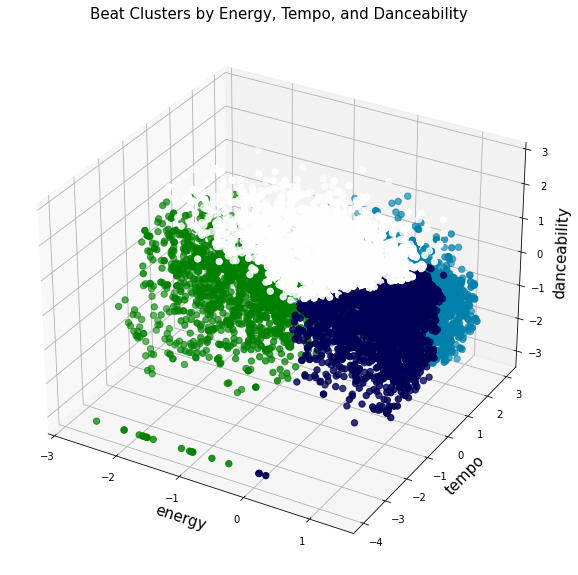

In [4]:
viz.beat_cluster(X_train_beat_cluster, centroids)


This cluster has four definitive clusters and may be used in modeling.

### Mood Cluster
mode, key, and valence

In [5]:
# define features for clustering
X_train_mood_cluster = train_scaled[['mode','key','valence']]
X_validate_mood_cluster = validate_scaled[['mode','key','valence']]
X_test_mood_cluster = test_scaled[['mode','key','valence']]

# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 222)
# fit cluster object to features
kmeans.fit(X_train_mood_cluster)
# use the object
train_scaled['mood_cluster'] = kmeans.predict(X_train_mood_cluster)
validate_scaled['mood_cluster'] = kmeans.predict(X_validate_mood_cluster)
test_scaled['mood_cluster'] = kmeans.predict(X_test_mood_cluster)
X_train_mood_cluster['mood_cluster'] = kmeans.predict(X_train_mood_cluster)


#define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_mood_cluster.loc[:, X_train_mood_cluster.columns != 'mood_cluster'].columns)

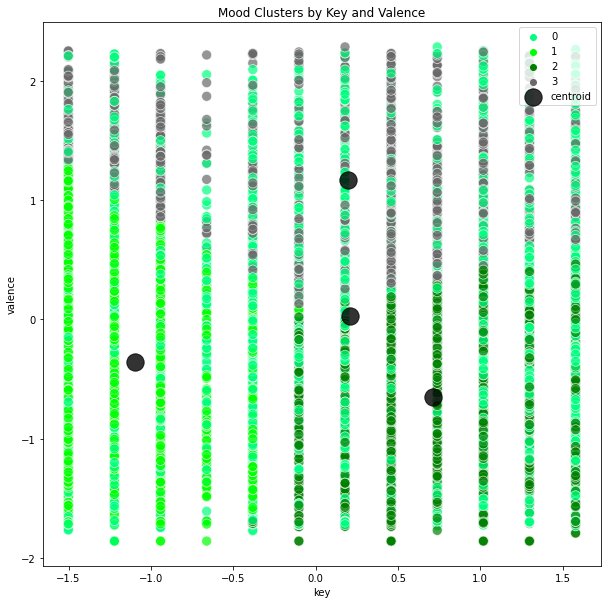

In [6]:
viz.mood_cluster(X_train_mood_cluster, centroids)


This cluster has a lot of overlap and might not be useful in modeling.

### Ambience Cluster
acousticness, intrumentalness, loudness

In [7]:
# define features for clustering
X_train_ambience_cluster = train_scaled[['acousticness','instrumentalness','loudness']]
X_validate_ambience_cluster = validate_scaled[['acousticness','instrumentalness','loudness']]
X_test_ambience_cluster = test_scaled[['acousticness','instrumentalness','loudness']]

# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 222)
# fit cluster object to features
kmeans.fit(X_train_ambience_cluster)
# use the object
train_scaled['ambience_cluster'] = kmeans.predict(X_train_ambience_cluster)
validate_scaled['ambience_cluster'] = kmeans.predict(X_validate_ambience_cluster)
test_scaled['ambience_cluster'] = kmeans.predict(X_test_ambience_cluster)
X_train_ambience_cluster['ambience_cluster'] = kmeans.predict(X_train_ambience_cluster)


#define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_ambience_cluster.loc[:, X_train_ambience_cluster.columns != 'ambience_cluster'].columns)

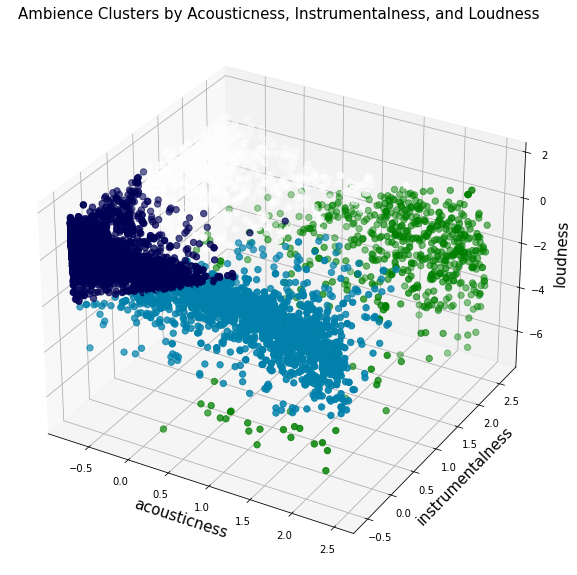

In [8]:
viz.ambience_cluster(X_train_ambience_cluster, centroids)


This cluster has four definitive clusters and may be used in modeling.

## Clustering Summary

The mood clusters have too much overlap to be useful, I expect this is because the features included are mostly categorical in nature.

The beat and ambience clusters have a pretty distinct split. Statistical tests  will evaluate correlation with popularity.

## Exploratory Analysis
### What correlates with popularity?
Beat clusters, ambience clusters, and audio features correlations with popularity are assessed.

In [9]:
# import statistics module and establish alpha
from scipy import stats
alpha = 0.5

1. Is popularity different between clusters based on house features?

Run anova test
$H:0$
: Means of the logerror between clusters are equal

H
a
 Means of the logerror between clusters are not equal

In [10]:
x = train_scaled.beat_cluster
y = train_scaled.popularity

corr, p = stats.pearsonr(x, y)

if p < alpha:
    print('There is a correlation between beat clusters and popularity')
else:
    print('There is no correlation between beat clusters and popularity')

There is a correlation between beat clusters and popularity


In [11]:
viz.stats_beat()

AttributeError: module 'viz' has no attribute 'stats_beat'

In [ ]:
x = train_scaled.ambience_cluster
y = train_scaled.popularity

corr, p = stats.pearsonr(x, y)

if p < alpha:
    print('There is a correlation between ambience clusters and popularity')
else:
    print('There is no correlation between ambience clusters and popularity')

There is a correlation between ambience clusters and popularity


In [ ]:
viz.stats_ambience()

In [ ]:
x = train_scaled.danceability
y = train_scaled.popularity

corr, p = stats.pearsonr(x, y)

if p < alpha:
    print('There is a correlation between danceability and popularity')
else:
    print('There is no correlation between danceability and popularity')

There is a correlation between danceability and popularity


In [ ]:
viz.stats_danceability()

In [ ]:
x = train_scaled.loudness
y = train_scaled.popularity

corr, p = stats.pearsonr(x, y)

if p < alpha:
    print('There is a correlation between loudness and popularity')
else:
    print('There is no correlation between loudness and popularity')

There is a correlation between loudness and popularity


In [ ]:
viz.stats_loudness()

### Drivers of popularity?
